In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from einops import rearrange, repeat
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

import sys
sys.path.append('/home/wxd/video-generation/diffusers/src')

from diffusers.models.unet_spatio_temporal_condition import UNetSpatioTemporalConditionModel
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKLTemporalDecoder, EulerDiscreteScheduler
from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion import StableVideoDiffusionPipeline

In [2]:
pretrained_model_name_or_path = '/ssd_datasets/wxiaodong/ckpt/video-s256-svd-ep40'

# have to align with the training vae
vae = AutoencoderKL.from_pretrained(
            pretrained_model_name_or_path, subfolder="vae"
)

vae.eval()
vae.to('cuda:7')

scheduler = EulerDiscreteScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
feature_extractor = CLIPImageProcessor.from_pretrained(pretrained_model_name_or_path, subfolder="feature_extractor")

image_encoder = CLIPVisionModelWithProjection.from_pretrained(pretrained_model_name_or_path, subfolder="image_encoder")
image_encoder.to('cuda:7')

unet = UNetSpatioTemporalConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")
unet.eval()
unet = unet.to('cuda:7')

In [3]:
pipeline = StableVideoDiffusionPipeline(
            vae=vae,
            unet=unet,
            image_encoder=image_encoder,
            scheduler=scheduler,
            feature_extractor=feature_extractor
)
pipeline = pipeline.to('cuda:7')

In [4]:
### test examples
import os
files = os.listdir('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames')

In [8]:
from PIL import Image
import numpy as np

file_idx = 4
image_path = os.path.join('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames', files[file_idx])
print(files[file_idx])
image = Image.open(image_path)

n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151418112404.jpg


In [9]:
frames = pipeline(image, num_frames=8, height=256, width=512, fps=3, max_guidance_scale=1.0).frames[0]

#save first 8 frames
# frames[0] = image.resize((512, 256)).convert('RGB')
# frames[0]
# default saving method in diffusers
# from diffusers.utils import export_to_video
# export_to_video(frames, f"svd_val_{file_idx}_s256_8f.mp4", fps=6)

image_embeddings shape: torch.Size([1, 1, 1024])


  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
# Original Stabel Video Diffusion
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "/ssd_datasets/wxiaodong/ckpt/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe = pipe.to('cuda:7')

In [4]:
### test examples
import os
files = os.listdir('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames')

from PIL import Image
import numpy as np

file_idx = 4
image_path = os.path.join('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames', files[file_idx])
print(files[file_idx])
image = Image.open(image_path)

n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151418112404.jpg


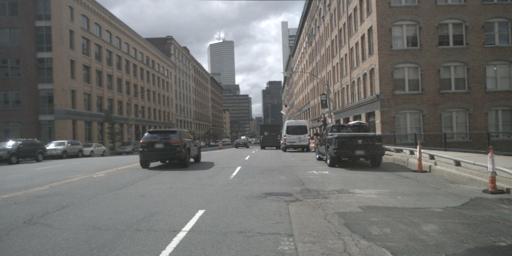

In [20]:
image = image.resize((512, 256))
image

In [22]:
image.save(f'val_{file_idx}_s256.jpg')

In [29]:
frames = pipe(image, num_frames=8, motion_bucket_id=200, max_guidance_scale=1.0).frames[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [30]:
from diffusers.utils import export_to_video
export_to_video(frames, f"ori_svd_val_{file_idx}_8f_motion_200_cfg.mp4", fps=6)

'ori_svd_val_4_8f_motion_200_cfg.mp4'